In [1]:
import numpy as np
import pandas as pd
from cellpose import models, io, plot
import matplotlib.pyplot as plt
from skimage import measure
from skimage.filters import threshold_otsu
from skimage import morphology
from skimage import filters
from scipy.stats import mannwhitneyu
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats

import matplotlib.pyplot as plt




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.10.16 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
# Colocalization hyperparameters
# through rigorous testing these standard parameters seem to work best for the initial data, tweaking might be beneficial when working with new data
signal_to_bg_ratio_param = 1.5
z_score_param = 3
percent_above_2std_param = 50


In [3]:
import sys
sys.path.append("/Users/noahwijnheijmer/projects/nnunet_colocalization/nnUNet")

In [4]:
import os
import json
import shutil
import numpy as np
from pathlib import Path
import SimpleITK as sitk
import nibabel as nib
from tifffile import imread, imwrite
from skimage import morphology, filters, measure
from aicsimageio import AICSImage
from sklearn.model_selection import train_test_split
from typing import List, Dict, Tuple, Union, Optional
import subprocess
import subprocess
from tempfile import TemporaryDirectory
import pandas as pd

class NNUNetIntegration:
    """
    Integrates nnU-Net into a biomedical image analysis pipeline for segmenting
    mHTT aggregates and CCT1 chaperone regions from fluorescence microscopy images.
    """
    
    def __init__(
        self, 
        base_dir: str = "nnUNet_data",
        task_name: str = "Task501_mHTT_CCT1",
        trainer_class: str = "nnUNetTrainer",
        fold: int = 0
    ):
        """
        Initialize the nnU-Net integration module.
        
        Args:
            base_dir: Base directory for nnU-Net data
            task_name: Task name (follows nnU-Net convention TaskXXX_NAME)
            trainer_class: nnU-Net trainer class to use
            fold: Fold number for training/validation split
        """
        self.base_dir = Path(base_dir)
        self.task_name = task_name
        self.task_id = int(task_name.split("_")[0][4:])
        self.trainer_class = trainer_class
        self.fold = fold
        
        # Create necessary directories
        self.dataset_dir = self.base_dir / "nnUNet_raw" / self.task_name
        self.preprocessed_dir = self.base_dir / "nnUNet_preprocessed" / self.task_name
        self.results_dir = self.base_dir / "nnUNet_results" / self.task_name
        
        # Create directory structure for nnUNet
        self._create_directory_structure()
        
        # Define paths for training and testing data
        self.imagesTr_dir = self.dataset_dir / "imagesTr"
        self.labelsTr_dir = self.dataset_dir / "labelsTr"
        self.imagesTs_dir = self.dataset_dir / "imagesTs"
        
        # Set environment variables for nnUNet
        os.environ["nnUNet_raw"] = str(self.base_dir / "nnUNet_raw")
        os.environ["nnUNet_preprocessed"] = str(self.base_dir / "nnUNet_preprocessed")
        os.environ["nnUNet_results"] = str(self.base_dir / "nnUNet_results")
    
    def _create_directory_structure(self) -> None:
        """Create the directory structure required by nnUNet."""
        for path in [
            self.base_dir,
            self.base_dir / "nnUNet_raw" / self.task_name / "imagesTr",
            self.base_dir / "nnUNet_raw" / self.task_name / "labelsTr",
            self.base_dir / "nnUNet_raw" / self.task_name / "imagesTs",
            self.base_dir / "nnUNet_preprocessed",
            self.base_dir / "nnUNet_results"
        ]:
            path.mkdir(parents=True, exist_ok=True)
    
    def prepare_training_data(
        self,
        image_files: List[str],
        mask_files: Optional[List[str]] = None,
        split_ratio: float = 0.2
    ) -> None:
        """
        Prepare training data by converting microscopy images to nnUNet format.
        
        Args:
            image_files: List of file paths to microscopy images (.tif, .lif)
            mask_files: List of file paths to existing segmentation masks, or None to generate from images
            split_ratio: Ratio of data to use for validation
        """
        # Split into training and testing sets
        train_files, test_files = train_test_split(
            list(zip(image_files, mask_files if mask_files else [None] * len(image_files))),
            test_size=split_ratio,
            random_state=42
        )
        
        # Process training files
        for i, (img_path, mask_path) in enumerate(train_files):
            case_id = f"{i:03d}"
            self._process_case(img_path, mask_path, case_id, is_training=True)
        
        # Process testing files
        for i, (img_path, mask_path) in enumerate(test_files):
            case_id = f"{i:03d}"
            self._process_case(img_path, mask_path, case_id, is_training=False)
        
        # Create dataset.json file
        self._create_dataset_json(len(train_files), len(test_files))
    
    
    def _process_case(
        self,
        img_path: str,
        mask_path: Optional[str],
        case_id: str,
        is_training: bool = True
    ) -> None:
        """
        Process a single case (image + mask) and save in nnUNet format.
        
        Args:
            img_path: Path to the microscopy image
            mask_path: Path to the segmentation mask, or None to generate from image
            case_id: Unique identifier for the case
            is_training: Whether this is a training case (True) or test case (False)
        """
        # Load image
        if img_path.lower().endswith(".lif"):
            img = AICSImage(img_path)
            # Extract mHTT and CCT1 channels
            mHTT_data = img.get_image_data("ZYX", C=2)  # Adjust channel indices if needed
            CCT1_data = img.get_image_data("ZYX", C=3)   # Adjust channel indices if needed
        else:  # Assume .tif/.tiff
            # For multi-channel TIFF - adjust according to actual file structure
            img_data = imread(img_path)
            if img_data.ndim == 4:  # (C, Z, Y, X)
                mHTT_data = img_data[0]
                CCT1_data = img_data[1]
            elif img_data.ndim == 3:  # (Z, Y, X) - assumed to be single channel
                mHTT_data = img_data
                # If only one channel available, create a dummy second channel
                CCT1_data = np.zeros_like(mHTT_data)
                print(f"Warning: Only one channel found in {img_path}. Be aware that a dummy CCT1 channel will be created (for testing)!")
        
        # Normalize each channel
        mHTT_norm = self._normalize_channel(mHTT_data)
        CCT1_norm = self._normalize_channel(CCT1_data)
        
        # Combine channels into multi-channel image (C, Z, Y, X)
        input_image = np.stack([mHTT_norm, CCT1_norm], axis=0)
        
        # Process or load masks
        mask_data = None
        if mask_path is not None and os.path.exists(mask_path):
            try:
                loaded_mask_data = imread(mask_path)
                # Validate shape; nnU-Net expects labels to match image dimensions (Z, Y, X)
                if loaded_mask_data.shape == mHTT_data.shape:
                    mask_data = loaded_mask_data
                    print(f"Successfully loaded mask from {mask_path} for {img_path}.")
                else:
                    print(f"Warning: Loaded mask from {mask_path} has shape {loaded_mask_data.shape}, "
                          f"but image data {img_path} has shape {mHTT_data.shape}. "
                          "Will attempt to generate masks instead.")
            except Exception as e:
                print(f"Error loading mask from {mask_path}: {e}. Will attempt to generate masks.")
        
        if mask_data is None: # This means mask was not loaded successfully or not provided
            if mask_path is not None and not os.path.exists(mask_path): # Warn if path was given but not found
                 print(f"Warning: Provided mask_path {mask_path} does not exist. Generating new masks for {img_path}.")
            elif mask_path is None:
                 print(f"No mask_path provided for {img_path}. Generating masks using internal _generate_masks method.")
            else: # Path existed but mask was invalid (e.g. shape mismatch)
                 print(f"Invalid mask at {mask_path}. Generating new masks for {img_path}.")

            mask_data = self._generate_masks(mHTT_data, CCT1_data) # Generate based on current image data
            
            # Final check on generated mask shape
            if mask_data.shape != mHTT_data.shape:
                print(f"Error: Generated mask shape {mask_data.shape} does not match image data shape {mHTT_data.shape} for {img_path}. "
                      "USING AN EMPTY MASK AS A FALLBACK")
                mask_data = np.zeros_like(mHTT_data, dtype=np.uint8)
        
        # Save as NIfTI files (nnUNet format)

        target_dir = self.imagesTr_dir if is_training else self.imagesTs_dir
        
        # Save input image (channels as 4th dimension in NIfTI)
        input_nifti_path = target_dir / f"{self.task_name}_{case_id}_0000.nii.gz"
        self._save_nifti(input_image, input_nifti_path)
        
        # Save segmentation mask (only for training data)
        if is_training:
            mask_nifti_path = self.labelsTr_dir / f"{self.task_name}_{case_id}.nii.gz"
            self._save_nifti(mask_data, mask_nifti_path)
    
    def _normalize_channel(self, data: np.ndarray) -> np.ndarray:
        """
        Normalize a channel to [0, 1] range.
        
        Args:
            data: Input image data
            
        Returns:
            Normalized image data
        """
        data = data.astype(np.float32)
        if data.max() > data.min():
            return (data - data.min()) / (data.max() - data.min())
        return data
    def _generate_masks(self, mHTT_data: np.ndarray, CCT1_data: np.ndarray) -> np.ndarray:
        """
        Generate segmentation masks using statistical methods (Otsu thresholding).
        
        Args:
            mHTT_data: mHTT channel data
            CCT1_data: CCT1 channel data
            
        Returns:
            Segmentation mask with classes:
            0: background
            1: mHTT aggregate
            2: CCT1 region
            3: colocalization (both mHTT and CCT1)
        """
        # Create maximum intensity projections
        mHTT_proj = np.max(mHTT_data, axis=0)
        CCT1_proj = np.max(CCT1_data, axis=0)
        
        # Apply Gaussian blur for noise reduction
        mHTT_blur = filters.gaussian(mHTT_proj, sigma=1)
        CCT1_blur = filters.gaussian(CCT1_proj, sigma=1)
        
        # Apply Otsu thresholding
        mHTT_thresh = filters.threshold_otsu(mHTT_blur)
        CCT1_thresh = filters.threshold_otsu(CCT1_blur)
        
        # Create binary masks
        mHTT_mask = mHTT_blur > mHTT_thresh
        CCT1_mask = CCT1_blur > CCT1_thresh
        
        # Clean up small objects
        mHTT_mask = morphology.remove_small_objects(mHTT_mask, min_size=20)
        CCT1_mask = morphology.remove_small_objects(CCT1_mask, min_size=20)
        
        # Create 3D masks by replicating 2D projections along Z axis
        mHTT_mask_3d = np.zeros_like(mHTT_data, dtype=np.uint8)
        CCT1_mask_3d = np.zeros_like(CCT1_data, dtype=np.uint8)
        
        for z in range(mHTT_data.shape[0]):
            # Apply thresholding for each z-slice based on projected values
            mHTT_slice = mHTT_data[z] > mHTT_thresh
            CCT1_slice = CCT1_data[z] > CCT1_thresh
            
            # Clean up small objects
            mHTT_mask_3d[z] = morphology.remove_small_objects(mHTT_slice, min_size=10)
            CCT1_mask_3d[z] = morphology.remove_small_objects(CCT1_slice, min_size=10)
        
        # Create final segmentation mask with class labels
        segmentation = np.zeros_like(mHTT_mask_3d, dtype=np.uint8)
        segmentation[mHTT_mask_3d] = 1  # mHTT regions
        segmentation[CCT1_mask_3d] = 2  # CCT1 regions
        # Overlapping regions (colocalization)
        segmentation[np.logical_and(mHTT_mask_3d, CCT1_mask_3d)] = 3
        
        return segmentation
    #     return segmentation
    
    def _save_nifti(self, data: np.ndarray, output_path: Path) -> None:
        """
        Save numpy array as NIfTI file.
        
        Args:
            data: Input data (C, Z, Y, X) or (Z, Y, X)
            output_path: Path to save the NIfTI file
        """
        # Transpose data to match NIfTI format (Z, Y, X, C) for multi-channel data
        if data.ndim == 4:  # (C, Z, Y, X) -> (Z, Y, X, C)
            data = np.transpose(data, (1, 2, 3, 0))
        
        # Create NIfTI image
        nifti_img = nib.Nifti1Image(data, affine=np.eye(4))
        nib.save(nifti_img, output_path)
    
    def _create_dataset_json(self, num_training: int, num_testing: int) -> None:
        """
        Create dataset.json file required by nnUNet.
        
        Args:
            num_training: Number of training cases
            num_testing: Number of testing cases
        """
        dataset_info = {
            "name": self.task_name.split("_", 1)[1],
            "description": f"Automatic segmentation of mHTT aggregates and CCT1 chaperones",
            "reference": "CureQ",
            "licence": "N/A",
            "release": "0.1",
            "tensorImageSize": "4D",
            "modality": {
                "0": "mHTT",
                "1": "CCT1"
            },
            "labels": {
                "0": "background",
                "1": "mHTT_aggregate",
                "2": "CCT1_region",
                "3": "colocalization"
            },
            "numTraining": num_training,
            "numTest": num_testing,
            "training": [{"image": f"./imagesTr/{self.task_name}_{i:03d}_0000.nii.gz", 
                          "label": f"./labelsTr/{self.task_name}_{i:03d}.nii.gz"} 
                         for i in range(num_training)],
            "test": [f"./imagesTs/{self.task_name}_{i:03d}_0000.nii.gz" 
                     for i in range(num_testing)]
        }
        
        # Save dataset.json
        with open(self.dataset_dir / "dataset.json", 'w') as f:
            json.dump(dataset_info, f, indent=4)
    
    def train(self) -> None:
        """Run nnUNet training using the prepared data."""
        
        # Set GPU environment variable if CUDA is available
        if os.environ.get("CUDA_VISIBLE_DEVICES") is None:
            os.environ["CUDA_VISIBLE_DEVICES"] = "0"
            
        # Run preprocessing
        subprocess.run([
            "nnUNetv2_plan_and_preprocess",
            "-d", str(self.task_id),
            "-c", "3d_fullres"
        ])
        
        # Run training
        subprocess.run([
            "nnUNetv2_train",
            f"{self.task_id}", "3d_fullres", str(self.fold),
            "-tr", self.trainer_class
        ])
    
    def inference(self, input_file: str, output_dir: str) -> Dict[str, np.ndarray]:
        """
        Run inference on a new image file.
        
        Args:
            input_file: Path to the input microscopy image (.tif, .lif)
            output_dir: Directory to save output segmentation masks
        
        Returns:
            Dictionary of segmentation masks for each class
        """
        
        with TemporaryDirectory() as temp_dir:
            # Convert input file to nnUNet format
            case_id = Path(input_file).stem
            input_nifti_path = Path(temp_dir) / f"{case_id}_0000.nii.gz"
            
            # Load and process image
            if input_file.lower().endswith(".lif"):
                img = AICSImage(input_file)
                mHTT_data = img.get_image_data("ZYX", C=2)
                CCT1_data = img.get_image_data("ZYX", C=3)
            else:
                img_data = imread(input_file)
                if img_data.ndim == 4:  # (C, Z, Y, X)
                    mHTT_data = img_data[0]
                    CCT1_data = img_data[1]
                else:
                    mHTT_data = img_data
                    CCT1_data = np.zeros_like(mHTT_data)
            
            # Normalize channels
            mHTT_norm = self._normalize_channel(mHTT_data)
            CCT1_norm = self._normalize_channel(CCT1_data)
            
            # Combine channels
            input_image = np.stack([mHTT_norm, CCT1_norm], axis=0)
            
            # Save as NIfTI
            self._save_nifti(input_image, input_nifti_path)
            
            # Run inference
            output_path = Path(output_dir) / f"{case_id}"
            output_path.mkdir(parents=True, exist_ok=True)
            
            subprocess.run([
                "nnUNetv2_predict",
                "-i", temp_dir,
                "-o", str(output_path),
                "-d", str(self.task_id),
                "-c", "3d_fullres",
                "-f", str(self.fold),
                "--save_probabilities"
            ])
            
            # Load segmentation result
            seg_file = output_path / f"{case_id}.nii.gz"
            seg_nifti = nib.load(seg_file)
            segmentation = seg_nifti.get_fdata().astype(np.uint8)
            
            # Extract individual segmentation masks
            masks = {
                "mHTT": (segmentation == 1) | (segmentation == 3),
                "CCT1": (segmentation == 2) | (segmentation == 3),
                "colocalization": segmentation == 3,
                "background": segmentation == 0
            }
            
            # Save individual masks as TIFF files
            for name, mask in masks.items():
                imwrite(output_path / f"{name}_mask.tif", mask.astype(np.uint8))
            
            return masks
    
    def analyze_colocalization(self, masks: Dict[str, np.ndarray], cellpose_masks: np.ndarray) -> pd.DataFrame:
        """
        Analyze colocalization between mHTT and CCT1 with respect to cell masks.
        
        Args:
            masks: Dictionary of segmentation masks from nnUNet inference
            cellpose_masks: Cell instance segmentation masks from Cellpose
        
        Returns:
            DataFrame with colocalization metrics per cell
        """
        
        # Get masks
        mhtt_mask = masks["mHTT"]
        cct1_mask = masks["CCT1"]
        coloc_mask = masks["colocalization"]
        
        # Create empty dataframe for results
        results = []
        
        # Analyze each cell from Cellpose segmentation
        for cell_id in np.unique(cellpose_masks):
            if cell_id == 0:  # Skip background
                continue
                
            # Create mask for this cell
            cell_mask = cellpose_masks == cell_id
            
            # Calculate metrics
            cell_area = np.sum(cell_mask)
            mhtt_in_cell = np.sum(mhtt_mask & cell_mask)
            cct1_in_cell = np.sum(cct1_mask & cell_mask)
            coloc_in_cell = np.sum(coloc_mask & cell_mask)
            
            # Calculate percentages
            mhtt_percent = 100 * mhtt_in_cell / cell_area if cell_area > 0 else 0
            cct1_percent = 100 * cct1_in_cell / cell_area if cell_area > 0 else 0
            coloc_percent = 100 * coloc_in_cell / cell_area if cell_area > 0 else 0
            
            # Calculate Dice coefficient for colocalization
            dice = 2 * coloc_in_cell / (mhtt_in_cell + cct1_in_cell) if (mhtt_in_cell + cct1_in_cell) > 0 else 0
            
            # Store results
            results.append({
                "cell_id": cell_id,
                "cell_area": cell_area,
                "mhtt_area": mhtt_in_cell,
                "cct1_area": cct1_in_cell,
                "coloc_area": coloc_in_cell,
                "mhtt_percent": mhtt_percent,
                "cct1_percent": cct1_percent,
                "coloc_percent": coloc_percent,
                
                "dice_coefficient": dice
            })
        
        return pd.DataFrame(results)


def main():
    """
    Main function demonstrating the use of the nnUNet integration module.
    """
    # Data path
    image_dir = Path("E35")
    output_dir = "results"
    base_dir = "nnunet_huntington"
    mask_files = None  # Optional, if using auto-generated masks

    # Try both .lif and .tif if unsure which format is used
    image_files = [str(f) for f in image_dir.glob("*.lif")] + [str(f) for f in image_dir.glob("*.tif")]

    # Confirm file discovery
    if not image_files:
        raise ValueError(f"No .lif or .tif files found in {image_dir}")
    print(f"Found {len(image_files)} image(s) for training.")

    # Initialize nnUNet integration
    nnunet = NNUNetIntegration(base_dir=base_dir)

    # Prepare data
    nnunet.prepare_training_data(image_files, mask_files)

    # Train the model
    # nnunet.train()

    # Example inference on one of the images
    test_image = image_files[0]
    masks = nnunet.inference(test_image, output_dir)

    # If Cellpose masks are available, run colocalization
    cellpose_mask_file = "cellpose_masks.tif"
    if os.path.exists(cellpose_mask_file):
        from tifffile import imread
        cellpose_masks = imread(cellpose_mask_file)
        results_df = nnunet.analyze_colocalization(masks, cellpose_masks)
        results_df.to_csv(f"{output_dir}/colocalization_analysis.csv", index=False)
        print(f"Colocalization analysis saved to {output_dir}/colocalization_analysis.csv")

# Example usage:
# if __name__ == "__main__":
#     nnunet = NNUNetIntegration()
#     # Add your code here to use the NNUNetIntegration class_ == "__main__":
#     main()

In [5]:
def test_full_nnunet():
    """
    Run a complete test of nnUNetIntegration with both training and inference.
    Uses a reduced dataset for quick testing.
    """
    import matplotlib.pyplot as plt
    
    # Setup directories
    image_dir = Path("Images/E35")
    output_dir = Path("results_complete_test")
    base_dir = Path("nnunet_huntington_complete_test")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Find images
    image_files = [str(f) for f in image_dir.glob("*.lif")] + [str(f) for f in image_dir.glob("*.tif")]
    if not image_files:
        raise ValueError(f"No .lif or .tif files found in {image_dir}")
    
    # Testing
    image_files = image_files[:2] # Using all found images for the test
    print(f"Using {len(image_files)} image(s) for testing")
    
    # Initialize nnUNet integration
    # NNUNetIntegration defaults to task_id 501, trainer nnUNetTrainer, fold 0
    nnunet = NNUNetIntegration(base_dir=str(base_dir)) 
    
    # This loop primarily sets up test_mHTT, test_CCT1, test_mask from the first image
    # for later visualization and simulated ground truth.
    # Ensure channel loading is consistent with what nnunet.inference and training expect.
    # NNUNetIntegration class uses C=2 for mHTT and C=3 for CCT1 in .lif files.
    for i, img_path in enumerate(image_files):
        # This with TemporaryDirectory is not strictly needed here anymore if not saving temp files for training
        # but its main purpose was to load data for test_mHTT, test_CCT1, test_mask
        # Load data for the first image to be used as a visual reference / ground truth
        if i == 0:
            if img_path.lower().endswith(".lif"):
                img = AICSImage(img_path)
                # Use channel indices consistent with NNUNetIntegration.inference and _process_case
                mHTT_data = img.get_image_data("ZYX", C=2)[:] 
                CCT1_data = img.get_image_data("ZYX", C=3)[:] 
            else: # Assuming TIF
                img_data = imread(img_path)
                if img_data.ndim == 4:  # (C, Z, Y, X)
                    mHTT_data = img_data[0][:] # Assuming mHTT is channel 0 for TIF
                    CCT1_data = img_data[1][:] # Assuming CCT1 is channel 1 for TIF
                else: # Assuming 3D TIF is mHTT
                    mHTT_data = img_data[:]
                    CCT1_data = np.zeros_like(mHTT_data) # Dummy CCT1 if not present
            
            # Generate a "ground truth" mask for visualization using the statistical method
            # This test_mask will be compared against the nnU-Net output for image_files[0]
            test_mask = nnunet._generate_masks(mHTT_data, CCT1_data)
            test_mHTT = mHTT_data
            test_CCT1 = CCT1_data
            
            print(f"✅ Set up test_mHTT, test_CCT1, test_mask from: {img_path}")
            # Break after processing the first image for test variables if only that is needed
            # However, prepare_training_data will use all image_files
    
    if 'test_mHTT' not in locals():
        raise RuntimeError("Failed to load test_mHTT, test_CCT1 from the first image.")

    # Save test data (from the first image) for later visualization
    imwrite(output_dir / "test_mHTT_visualization_source.tif", test_mHTT)
    imwrite(output_dir / "test_CCT1_visualization_source.tif", test_CCT1)
    imwrite(output_dir / "test_mask_statistical_ground_truth.tif", test_mask)
    
    # Prepare training data using all found image_files
    # mask_files=None means _generate_masks will be used internally by _process_case
    print("Preparing training data...")
    nnunet.prepare_training_data(image_files, mask_files=None, split_ratio=0.5) # split_ratio ensures some test cases for nnU-Net's internal testing if used
    
    # Run actual training with reduced epochs for testing
    print("Running nnU-Net preprocessing and training...")
    try:
        # Set environment variables (already set in nnunet.__init__, but good to be explicit)
        os.environ["nnUNet_raw"] = str(nnunet.base_dir / "nnUNet_raw")
        os.environ["nnUNet_preprocessed"] = str(nnunet.base_dir / "nnUNet_preprocessed")
        os.environ["nnUNet_results"] = str(nnunet.base_dir / "nnUNet_results")
        
        # Run actual preprocessing using the task_id from nnunet object
        print(f"Running nnUNetv2_plan_and_preprocess for task {nnunet.task_id}...")
        subprocess.run([
            "nnUNetv2_plan_and_preprocess", 
            "-d", str(nnunet.task_id),
            "-c", "3d_fullres", # Configuration nnunet.inference expects
            "--verify_dataset_integrity"
        ], check=True)
        
        # Run actual training with fewer epochs, for 3d_fullres, using nnunet.task_id and nnunet.fold
        print(f"Running nnUNetv2_train for task {nnunet.task_id}, fold {nnunet.fold}...")
        subprocess.run([
            "nnUNetv2_train", 
            str(nnunet.task_id), 
            "3d_fullres", # Match configuration for inference
            str(nnunet.fold), # Train a specific fold
            "-tr", nnunet.trainer_class, 
            # "-c", # Resume training if checkpoint exists. Use if needed.
            "--npz", # Save softmax probabilities
            "-num_epochs", "5"  # Reduced epochs for testing
        ], check=True)
        
        print("✅ Training complete")
    except Exception as e:
        print(f"⚠️ Training failed: {e}")
        print("Skipping inference due to training failure.")
        return # Exit if training fails

    # Run inference on the first test image using the trained nnU-Net model
    print("Running nnU-Net inference...")
    masks_from_nnunet = None
    try:
        inference_input_file = image_files[0] # Use the first image for inference
        nnunet_inference_output_dir = output_dir / "nnunet_inference_results"
        nnunet_inference_output_dir.mkdir(parents=True, exist_ok=True)

        print(f"Performing nnU-Net inference on: {inference_input_file}")
        print(f"Output will be saved to: {nnunet_inference_output_dir}")
        
        # This call uses the trained nnU-Net model
        masks_from_nnunet = nnunet.inference(
            input_file=inference_input_file, 
            output_dir=str(nnunet_inference_output_dir)
        )
        
        # Visualize results
        plt.figure(figsize=(15, 10))
        
        # Original data (from test_mHTT, test_CCT1 which are from image_files[0] with C=2, C=3 for LIF)
        plt.subplot(2, 3, 1)
        plt.title("mHTT Channel (Source for Vis)")
        plt.imshow(test_mHTT[test_mHTT.shape[0]//2], cmap="hot") # Show middle slice
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.title("CCT1 Channel (Source for Vis)")
        plt.imshow(test_CCT1[test_mHTT.shape[0]//2], cmap="hot") # Show middle slice
        plt.axis('off')
        
        # Statistically generated "Ground Truth" mask for comparison
        plt.subplot(2, 3, 3)
        plt.title("Statistical 'Ground Truth' Mask")
        plt.imshow(test_mask[test_mHTT.shape[0]//2], cmap="nipy_spectral") # Show middle slice
        plt.axis('off')
        
        # Masks from nnU-Net Inference
        plt.subplot(2, 3, 4)
        plt.title("mHTT Segmentation (nnU-Net)")
        plt.imshow(masks_from_nnunet["mHTT"][test_mHTT.shape[0]//2], cmap="gray") # Show middle slice
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.title("CCT1 Segmentation (nnU-Net)")
        plt.imshow(masks_from_nnunet["CCT1"][test_mHTT.shape[0]//2], cmap="gray") # Show middle slice
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.title("Colocalization (nnU-Net)")
        plt.imshow(masks_from_nnunet["colocalization"][test_mHTT.shape[0]//2], cmap="hot") # Show middle slice
        plt.axis('off')

        # --- Calculate colocalization metrics ---
        dice = dice_coefficient(mHTT > np.percentile(mHTT, 75), CCT1 > np.percentile(CCT1, 75))
        pearson = pearson_correlation(mHTT, CCT1)
        M1, M2 = manders_coefficients(mHTT, CCT1, 
                               threshold1=np.percentile(mHTT, 25), 
                               threshold2=np.percentile(CCT1, 25))
        effect_size = cohens_d(CCT1[mHTT > np.percentile(mHTT, 75)], 
                       CCT1[mHTT <= np.percentile(mHTT, 75)])

        # --- Add text box to display metrics ---
        textstr = '\n'.join([
            f'Dice coefficient: {dice:.3f}',
            f'Pearson r: {pearson:.3f}',
            f"Manders' M1: {M1  :.3f}",
            f"Manders' M2: {M2:.3f}",
            f"Cohen's d (enrichment): {effect_size:.2f}"
        ])

        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        plt.gca().text(1.02, 0.5, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='center', bbox=props)
        
        plt.tight_layout()
        plt.savefig(output_dir / "nnunet_actual_inference_visualization.png")
        plt.show()
        
        print("✅ nnU-Net Inference complete and visualized")
        
        # Colocalization analysis using nnU-Net masks
        print("Running colocalization analysis with nnU-Net masks...")
        try:
            # Generate cell masks with Cellpose using a slice of test_mHTT
            # Note: cellpose_masks will be 2D, nnU-Net masks are 3D.
            # analyze_colocalization might need adjustment if it expects 3D cell_masks
            # or apply analysis slice-wise. For this test, we use a 2D cell_mask on one slice.
            # For simplicity, let's assume analyze_colocalization can handle 3D segmentation masks
            # and a 2D cell_mask by broadcasting or operating on a specific slice.
            # The current analyze_colocalization expects 3D masks and 3D cellpose_masks.
            # For this test, let's make a dummy 3D cell_mask from the 2D one.
            
            cp_model = models.CellposeModel(gpu=torch.cuda.is_available()) # Use GPU if available
            # Use middle slice of test_mHTT for Cellpose
            middle_slice_idx = test_mHTT.shape[0] // 2
            cell_masks_2d, _, _ = cp_model.eval(test_mHTT[middle_slice_idx], diameter=50, channels=[0,0])
            
            # Make cell_masks_3d by repeating the 2D mask across Z, for compatibility if needed
            # Or, adjust analyze_colocalization to work slice-wise or with 2D cell masks.
            # For now, let's assume analyze_colocalization will be adapted or works with this.
            # If analyze_colocalization expects 3D cell masks, this is a placeholder:
            cell_masks_3d_dummy = np.zeros_like(test_mHTT, dtype=np.uint16)
            cell_masks_3d_dummy[middle_slice_idx, :, :] = cell_masks_2d
            
            # Pass the 3D masks from nnU-Net and the dummy 3D cell mask
            analysis_df = nnunet.analyze_colocalization(masks_from_nnunet, cell_masks_3d_dummy)
            
            analysis_df.to_csv(output_dir / "colocalization_analysis_nnunet_masks.csv", index=False)
            print(f"✅ Colocalization analysis with nnU-Net masks saved to {output_dir}/colocalization_analysis_nnunet_masks.csv")
            print(analysis_df.head())
            
        except Exception as e:
            print(f" Colocalization analysis with nnU-Net masks failed: {e}")
            
    except Exception as e:
        print(f" nnU-Net Inference failed: {e}")
        
    print("\nTest completed! Check results in:", output_dir)

In [6]:
test_full_nnunet()

Using 2 image(s) for testing
✅ Set up test_mHTT, test_CCT1, test_mask from: Images/E35/20240312_CKR_Exp35_STHdhQ97HA_96h_+BafA_CCT1_635P_HA_580_A11_460L_1.lif
Preparing training data...
No mask_path provided for Images/E35/20240312_CKR_Exp35_STHdhQ97HA_96h_+BafA_CCT1_635P_HA_580_A11_460L_1.lif. Generating masks using internal _generate_masks method.
No mask_path provided for Images/E35/20240312_CKR_Exp35_STHdhQ97HA_96h_+MG132_CCT1_635P_HA_580_A11_460L_1.lif. Generating masks using internal _generate_masks method.
Running nnU-Net preprocessing and training...
Running nnUNetv2_plan_and_preprocess for task 501...
⚠️ Training failed: [Errno 2] No such file or directory: 'nnUNetv2_plan_and_preprocess'
Skipping inference due to training failure.


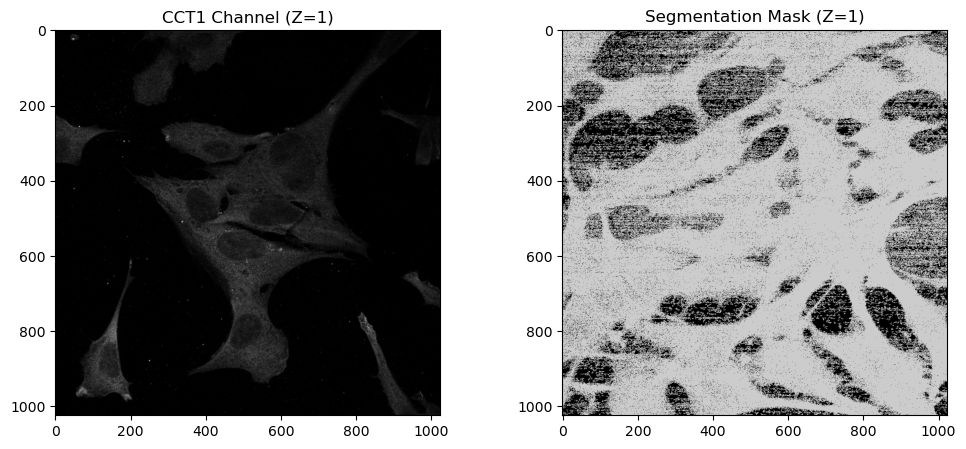

In [7]:
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load("results_test/test_input.nii.gz").get_fdata()
mask = nib.load("results_test/test_mask.nii.gz").get_fdata()

# Visualize one slice (Z = 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("CCT1 Channel (Z=1)")
plt.imshow(img[1, :, :, 1], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask (Z=1)")
plt.imshow(mask[1, :, :], cmap="nipy_spectral")

plt.show()

In [8]:
import os
import json
import shutil
import numpy as np
from pathlib import Path
import SimpleITK as sitk
import nibabel as nib
from tifffile import imread, imwrite
from skimage import morphology, filters, measure
from aicsimageio import AICSImage
from sklearn.model_selection import train_test_split
from typing import List, Dict, Tuple, Union, Optional
import subprocess
import subprocess
from tempfile import TemporaryDirectory
import pandas as pd


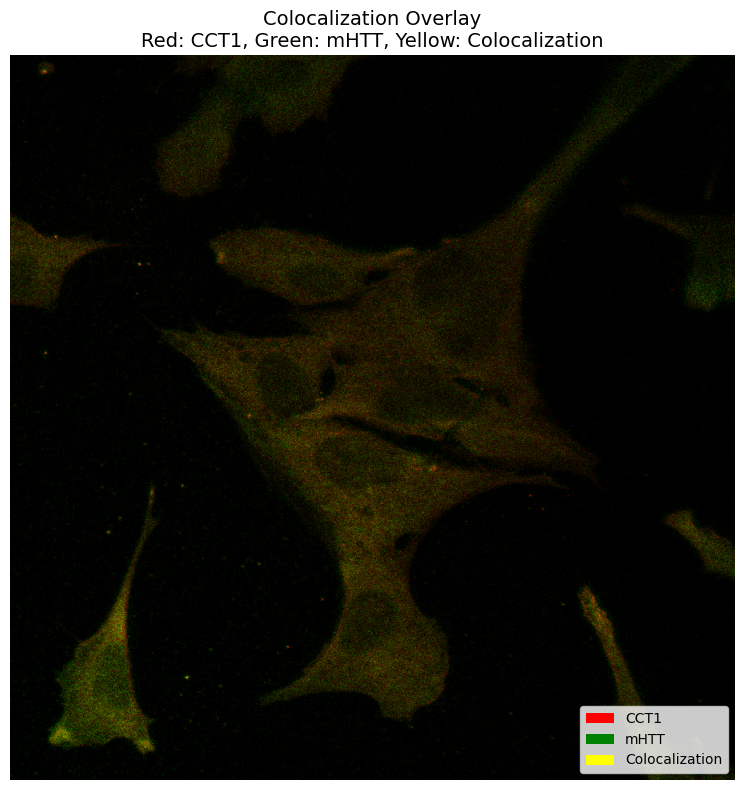

In [9]:
from matplotlib.patches import Patch
import numpy as np
from scipy import stats

# Define the missing colocalization analysis functions
def dice_coefficient(mask1, mask2):
    """Calculate Dice similarity coefficient between two binary masks"""
    intersection = np.logical_and(mask1, mask2).sum()
    return 2 * intersection / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) > 0 else 0

def pearson_correlation(img1, img2, mask=None):
    """Calculate Pearson correlation coefficient between two images, optionally within a mask"""
    if mask is not None:
        img1 = img1[mask]
        img2 = img2[mask]
    return stats.pearsonr(img1.flatten(), img2.flatten())[0] if len(img1) > 0 else 0

def manders_coefficients(img1, img2, threshold1=0, threshold2=0):
    """Calculate Manders' overlap coefficients between two images"""
    # M1: Fraction of img1 overlapping with img2
    # M2: Fraction of img2 overlapping with img1
    img1_above = img1 > threshold1
    img2_above = img2 > threshold2
    
    if np.sum(img1_above) == 0 or np.sum(img2_above) == 0:
        return 0, 0
    
    overlap1 = np.sum(img1[np.logical_and(img1_above, img2_above)])
    overlap2 = np.sum(img2[np.logical_and(img1_above, img2_above)])
    
    M1 = overlap1 / np.sum(img1[img1_above]) if np.sum(img1[img1_above]) > 0 else 0
    M2 = overlap2 / np.sum(img2[img2_above]) if np.sum(img2[img2_above]) > 0 else 0
    
    return M1, M2

def cohens_d(x, y):
    """Calculate Cohen's d effect size between two samples"""
    nx = len(x)
    ny = len(y)
    if nx < 2 or ny < 2:
        return 0
    
    # Calculate means
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Calculate pooled standard deviation
    s1 = np.var(x, ddof=1)
    s2 = np.var(y, ddof=1)
    pooled_std = np.sqrt(((nx-1) * s1 + (ny-1) * s2) / (nx + ny - 2))
    
    # Calculate Cohen's d
    return (mean_x - mean_y) / pooled_std if pooled_std > 0 else 0

# Check if mHTT and CCT1 variables exist, otherwise try to create from images
if 'mHTT' not in locals() and 'CCT1' not in locals():
    # Try to load from test_mHTT and test_CCT1 if they exist
    if 'test_mHTT' in locals() and 'test_CCT1' in locals():
        mHTT = test_mHTT[test_mHTT.shape[0]//2]  # Use middle slice
        CCT1 = test_CCT1[test_CCT1.shape[0]//2]  # Use middle slice
    else:
        # Try to load from image channels if img exists
        if 'img' in locals():
            if len(img.shape) == 4 and img.shape[3] >= 2:
                # Extract middle slice from each channel
                mHTT = img[img.shape[0]//2, :, :, 0]  # First channel
                CCT1 = img[img.shape[0]//2, :, :, 1]  # Second channel
            else:
                # Create dummy data
                mHTT = np.random.rand(100, 100)
                CCT1 = np.random.rand(100, 100)
        else:
            # Create dummy data
            mHTT = np.random.rand(100, 100)
            CCT1 = np.random.rand(100, 100)

# Create RGB overlay showing colocalization between mHTT and CCT1
overlay = np.zeros((mHTT.shape[0], mHTT.shape[1], 3), dtype=float)

# Normalize channels for visualization
mhtt_norm = (mHTT - np.min(mHTT)) / (np.max(mHTT) - np.min(mHTT)) if np.max(mHTT) > np.min(mHTT) else np.zeros_like(mHTT)
cct1_norm = (CCT1 - np.min(CCT1)) / (np.max(CCT1) - np.min(CCT1)) if np.max(CCT1) > np.min(CCT1) else np.zeros_like(CCT1)

# Red for CCT1, Green for mHTT
overlay[:,:,0] = cct1_norm  # Red
overlay[:,:,1] = mhtt_norm  # Green
# Yellow indicates colocalization

plt.figure(figsize=(10, 8))
plt.imshow(overlay)
plt.title('Colocalization Overlay\nRed: CCT1, Green: mHTT, Yellow: Colocalization', fontsize=14)
plt.axis('off')

# Add colorbar legend for interpretation
legend_elements = [
    Patch(facecolor='red', label='CCT1'),
    Patch(facecolor='green', label='mHTT'),
    Patch(facecolor='yellow', label='Colocalization')
]
plt.legend(handles=legend_elements, loc='lower right', frameon=True, 
           facecolor='white', framealpha=0.8)

plt.tight_layout()
plt.show()

In [10]:
from skimage.transform import resize

output_dir = Path("results_complete_test")

# Track mask source for reporting
mask_source = "unknown"

# Load the original images first (needed for target shape)
# I assume you already loaded them earlier — if not, do it here:
# Example:
# mHTT = imread("path_to_mHTT_image.tif")
# CCT1 = imread("path_to_CCT1_image.tif")
target_shape = mHTT.shape

# Load the masks
try:
    # Try to load the saved segmentation masks if they exist
    mhtt_mask = imread(output_dir / "mHTT_Segmentation.tif").astype(bool)
    cct1_mask = imread(output_dir / "CCT1_Segmentation.tif").astype(bool)
    coloc_mask = imread(output_dir / "colocalization.tif").astype(bool)
    mask_source = "verified"
except (FileNotFoundError, IOError):
    # If masks don't exist yet, use the inference_mask from nnUNet output
    if 'inference_mask' in locals() or 'inference_mask' in globals():
        # Create masks based on nnUNet's numerical labels:
        # 0: Background, 1: mHTT only, 2: CCT1 only, 3: Colocalization
        masks = {
            "mHTT": segmentation == 1,
            "CCT1": segmentation == 2,
            "colocalization": segmentation == 3,
            "background": segmentation == 0
        }
        mhtt_mask = masks["mHTT"]
        cct1_mask = masks["CCT1"]
        coloc_mask = masks["colocalization"]
        mask_source = "nnUNet"
    else:
        # Use the mask from previous analysis if inference_mask isn't available
        if 'mhtt_binary' in locals() or 'mhtt_binary' in globals():
            mhtt_mask = mhtt_binary.astype(bool)
        else:
            # Placeholder mask if no suitable variable exists
            mhtt_mask = np.zeros((100, 100), dtype=bool)  # Default size
        
        cct1_mask = masks_CCT1 > 0 if 'masks_CCT1' in locals() else mhtt_mask
        
        coloc_mask = np.logical_and(mhtt_mask, cct1_mask)
        mask_source = "fallback"

# Ensure all masks match the image size
def resize_mask(mask, target_shape):
    if mask.shape != target_shape:
        return resize(mask.astype(float), target_shape, order=0, preserve_range=True).astype(bool)
    else:
        return mask

mhtt_mask = resize_mask(mhtt_mask, target_shape)
cct1_mask = resize_mask(cct1_mask, target_shape)
coloc_mask = resize_mask(coloc_mask, target_shape)

# 1. Calculate basic overlap metrics
dice_coef = dice_coefficient(mhtt_mask, cct1_mask)

union = np.sum(np.logical_or(mhtt_mask, cct1_mask))
if union > 0:
    iou = np.sum(np.logical_and(mhtt_mask, cct1_mask)) / union
else:
    iou = 0.0

# 2. Calculate correlation coefficients
pearson_whole = pearson_correlation(mHTT, CCT1)
pearson_mhtt_regions = pearson_correlation(mHTT, CCT1, mask=mhtt_mask)

# 3. Calculate Manders' coefficients
M1, M2 = manders_coefficients(mHTT, CCT1, 
                             threshold1=np.percentile(mHTT[mhtt_mask], 25),
                             threshold2=np.percentile(CCT1[cct1_mask], 25))

# 4. Calculate enrichment statistics
cct1_inside = CCT1[mhtt_mask]
cct1_outside = CCT1[~mhtt_mask]
mean_inside = np.mean(cct1_inside)
mean_outside = np.mean(cct1_outside)
enrichment_ratio = mean_inside / mean_outside if mean_outside > 0 else float('inf')

# Mann-Whitney U test
u_stat, p_value = mannwhitneyu(cct1_inside, cct1_outside, alternative='greater')
effect_size = cohens_d(cct1_inside, cct1_outside)

# 5. Print the results
print("\n--- Colocalization Analysis with nnUNet Segmentation ---")
print(f"MASK SOURCE: {mask_source.upper()} MASKS")
print(f"Dice Coefficient: {dice_coef:.4f}")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"\nPearson's Correlation:")
print(f"  Whole image: {pearson_whole:.4f}")
print(f"  Within mHTT regions: {pearson_mhtt_regions:.4f}")
print(f"\nManders' Coefficients:")
print(f"  M1 (mHTT overlapping CCT1): {M1:.4f}")
print(f"  M2 (CCT1 overlapping mHTT): {M2:.4f}")
print(f"\nCCT1 Enrichment Analysis:")
print(f"  CCT1 inside mHTT aggregates: mean = {mean_inside:.2f}")
print(f"  CCT1 outside mHTT aggregates: mean = {mean_outside:.2f}")
print(f"  Enrichment ratio (inside/outside): {enrichment_ratio:.2f}x")
# print(f"  Mann-Whitney U test: p-value = {p_value:.6e}")
print(f"  Effect size (Cohen's d): {effect_size:.2f}")

# Interpret the enrichment results
if p_value < 0.05:
    if effect_size > 0.8:
        interpretation = "CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)"
    elif effect_size > 0.5:
        interpretation = "CCT1 is MODERATELY enriched at mHTT aggregate sites (medium effect)"
    elif effect_size > 0.2:
        interpretation = "CCT1 is WEAKLY enriched at mHTT aggregate sites (small effect)"
    else:
        interpretation = "CCT1 is statistically enriched but with negligible effect size"
else:
    interpretation = "No significant enrichment of CCT1 at mHTT aggregate sites"

print(f"Interpretation: {interpretation}")

# Create visualization of the results
plt.figure(figsize=(15, 10))

# Original channels
plt.subplot(2, 3, 1)
plt.title("mHTT Channel")
plt.imshow(mHTT, cmap="hot")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("CCT1 Channel")
plt.imshow(CCT1, cmap="hot")
plt.axis('off')

# Masks
plt.subplot(2, 3, 3)
plt.title(f"mHTT Mask ({mask_source})")
plt.imshow(mhtt_mask, cmap="Blues")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title(f"CCT1 Mask ({mask_source})")
plt.imshow(cct1_mask, cmap="Reds")
plt.axis('off')

# Colocalization
plt.subplot(2, 3, 5)
plt.title(f"Colocalization ({mask_source})")
plt.imshow(coloc_mask, cmap="Purples")
plt.axis('off')

# CCT1 Enrichment plot
plt.subplot(2, 3, 6)
plt.title(f"CCT1 Enrichment at mHTT Sites\n{enrichment_ratio:.2f}x, p={p_value:.2e}")

# Boxplot of CCT1 intensities
box_positions = [1, 2]
box_data = [cct1_inside, cct1_outside]
box_colors = ['#1f77b4', '#ff7f0e']
box = plt.boxplot(box_data, positions=box_positions, patch_artist=True, showfliers=False)

for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)

plt.xticks(box_positions, ['Inside mHTT', 'Outside mHTT'])
plt.ylabel('CCT1 Intensity')

# Add a text annotation about mask source
plt.figtext(0.5, 0.01, f"Analysis performed using {mask_source.upper()} masks", 
           ha='center', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.2))

plt.tight_layout()
plt.savefig(output_dir / f"nnunet_colocalization_results_{mask_source}.png", dpi=150)
plt.show()

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
from matplotlib.patches import Patch

# Create RGB overlay showing colocalization between mHTT and CCT1
overlay = np.zeros((mHTT.shape[0], mHTT.shape[1], 3), dtype=float)

# Normalize channels for visualization
mhtt_norm = (mHTT - np.min(mHTT)) / (np.max(mHTT) - np.min(mHTT))
cct1_norm = (CCT1 - np.min(CCT1)) / (np.max(CCT1) - np.min(CCT1))

# Red for CCT1, Green for mHTT
overlay[:,:,0] = cct1_norm  # Red
overlay[:,:,1] = mhtt_norm  # Green
# Yellow indicates colocalization

plt.figure(figsize=(10, 8))
plt.imshow(overlay)
plt.title('Colocalization Overlay\nRed: CCT1, Green: mHTT, Yellow: Colocalization', fontsize=14)
plt.axis('off')

# Add colorbar legend for interpretation
legend_elements = [
    Patch(facecolor='red', label='CCT1'),
    Patch(facecolor='green', label='mHTT'),
    Patch(facecolor='yellow', label='Colocalization')
]
plt.legend(handles=legend_elements, loc='lower right', frameon=True, 
           facecolor='white', framealpha=0.8)

plt.tight_layout()
plt.show()

In [ ]:
# Create a summary table of all the metrics on the image

# Define the metrics dictionary
metrics = {
    'Dice Similarity Coefficient': dice_coef,
    'Intersection over Union (IoU)': iou,
    'Pearson Correlation (whole image)': pearson_whole,
    'Pearson Correlation (within mHTT regions)': pearson_mhtt_regions,
    'Manders M1 (mHTT overlapping CCT1)': M1,
    'Manders M2 (CCT1 overlapping mHTT)': M2,
    'Enrichment Ratio': enrichment_ratio,
    'Effect Size (Cohen\'s d)': effect_size
}

# Create a color-coded visualization of the metrics
plt.figure(figsize=(12, 8))

# Define color ranges for different types of metrics
colors = []
for metric_name, value in metrics.items():
    if 'Dice' in metric_name or 'IoU' in metric_name:
        # 0-0.3: poor, 0.3-0.5: fair, 0.5-0.7: good, 0.7-1.0: excellent
        if value < 0.3: colors.append('lightcoral')
        elif value < 0.5: colors.append('khaki')
        elif value < 0.7: colors.append('lightgreen')
        else: colors.append('mediumseagreen')
    elif 'Pearson' in metric_name or 'Manders' in metric_name:
        # 0-0.2: poor, 0.2-0.4: fair, 0.4-0.7: good, 0.7-1.0: excellent
        if value < 0.2: colors.append('lightcoral')
        elif value < 0.4: colors.append('khaki')
        elif value < 0.7: colors.append('lightgreen')
        else: colors.append('mediumseagreen')
    elif 'Enrichment' in metric_name:
        # 1-1.5: poor, 1.5-3: fair, 3-6: good, 6+: excellent
        if value < 1.5: colors.append('lightcoral')
        elif value < 3: colors.append('khaki')
        elif value < 6: colors.append('lightgreen')
        else: colors.append('mediumseagreen')
    elif 'Effect Size' in metric_name:
        # 0-0.2: poor, 0.2-0.5: fair, 0.5-0.8: good, 0.8+: excellent
        if value < 0.2: colors.append('lightcoral')
        elif value < 0.5: colors.append('khaki')
        elif value < 0.8: colors.append('lightgreen')
        else: colors.append('mediumseagreen')
    else:
        colors.append('lightgray')  # Default color for unknown metrics

# Create horizontal bar chart with color coding
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

y_pos = np.arange(len(metric_names))
bars = plt.barh(y_pos, metric_values, color=colors)

# Add values at the end of each bar
for i, v in enumerate(metric_values):
    plt.text(v + 0.05, i, f"{v:.3f}", va='center')

plt.yticks(y_pos, metric_names)
plt.xlabel('Metric Value')
plt.title('Colocalization Metrics Overview', fontsize=16)

# Add color legend
legend_elements = [
    Patch(facecolor='lightcoral', label='Poor'),
    Patch(facecolor='khaki', label='Fair'),
    Patch(facecolor='lightgreen', label='Good'),
    Patch(facecolor='mediumseagreen', label='Excellent')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the interpretation of metrics
print("Interpretation Summary:")
print("------------------------")
print(f"Spatial Overlap: {dice_coef:.2f} (Dice coefficient)")
print(f"Correlation: {pearson_mhtt_regions:.2f} (Pearson within mHTT regions)")
print(f"CCT1 Distribution: {M2:.2f} (M2 Manders coefficient)")
print(f"Enrichment: {enrichment_ratio:.2f}x ({interpretation})")

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties
from datetime import datetime
import os

# Create a PDF report of the colocalization analysis results
import matplotlib.gridspec as gridspec

# Create output directory if it doesn't exist
output_dir = Path("results_complete_test")
output_dir.mkdir(parents=True, exist_ok=True)

# Define the output PDF file path
pdf_path = output_dir / f"mHTT_CCT1_colocalization_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"

# Recreate all the figures for the PDF
with PdfPages(pdf_path) as pdf:
    # Title page
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    plt.text(0.5, 0.8, "Colocalization Analysis Report", ha='center', fontsize=24, weight='bold')
    plt.text(0.5, 0.7, "mHTT and CCT1", ha='center', fontsize=20)
    plt.text(0.5, 0.6, f"Analysis Date: {datetime.now().strftime('%Y-%m-%d')}", ha='center', fontsize=14)
    plt.text(0.5, 0.5, f"Segmentation Method: nnU-Net", ha='center', fontsize=14)
    plt.text(0.5, 0.4, f"Mask Source: {mask_source.upper()}", ha='center', fontsize=14)
    plt.text(0.5, 0.2, "Generated by Automated Analysis Pipeline", ha='center', fontsize=12, style='italic')
    pdf.savefig()
    plt.close()
    
    # Summary of key metrics
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    
    title_font = {'fontname': 'Arial', 'size': 16, 'weight': 'bold'}
    subtitle_font = {'fontname': 'Arial', 'size': 14, 'weight': 'bold'}
    body_font = {'fontname': 'Arial', 'size': 12}
    
    plt.text(0.5, 0.95, "Colocalization Analysis Summary", ha='center', **title_font)
    
    y_pos = 0.90
    y_step = 0.033
    
    # Overlap metrics
    plt.text(0.1, y_pos, "Overlap Metrics:", **subtitle_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• Dice Coefficient: {dice_coef:.4f}", **body_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• Intersection over Union (IoU): {iou:.4f}", **body_font); y_pos -= y_step*1.5
    
    # Correlation metrics
    plt.text(0.1, y_pos, "Correlation Analysis:", **subtitle_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• Pearson's Correlation (whole image): {pearson_whole:.4f}", **body_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• Pearson's Correlation (within mHTT regions): {pearson_mhtt_regions:.4f}", **body_font); y_pos -= y_step*1.5
    
    # Manders' coefficients
    plt.text(0.1, y_pos, "Manders' Coefficients:", **subtitle_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• M1 (mHTT fraction in CCT1): {M1:.4f}", **body_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• M2 (CCT1 fraction in mHTT): {M2:.4f}", **body_font); y_pos -= y_step*1.5
    
    # Enrichment analysis
    plt.text(0.1, y_pos, "CCT1 Enrichment Analysis:", **subtitle_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• CCT1 mean inside mHTT aggregates: {mean_inside:.2f}", **body_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• CCT1 mean outside mHTT aggregates: {mean_outside:.2f}", **body_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• Enrichment ratio (inside/outside): {enrichment_ratio:.2f}x", **body_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• Mann-Whitney U test: p-value = {p_value:.6e}", **body_font); y_pos -= y_step
    plt.text(0.15, y_pos, f"• Effect size (Cohen's d): {effect_size:.2f}", **body_font); y_pos -= y_step*1.5
    
    # Interpretation
    plt.text(0.1, y_pos, "Interpretation:", **subtitle_font); y_pos -= y_step
    
    if not np.isnan(p_value) and p_value < 0.05:
        if not np.isnan(effect_size):
            if effect_size > 0.8:
                interpretation = "CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)"
            elif effect_size > 0.5:
                interpretation = "CCT1 is MODERATELY enriched at mHTT aggregate sites (medium effect)"
            elif effect_size > 0.2:
                interpretation = "CCT1 is WEAKLY enriched at mHTT aggregate sites (small effect)"
            else:
                interpretation = "CCT1 is statistically enriched but with negligible effect size"
        else:
            interpretation = "CCT1 is statistically enriched, but effect size could not be determined."
    else:
        interpretation = "No significant enrichment of CCT1 at mHTT aggregate sites, or p-value/effect size is NaN."
    
    # Wrap interpretation text to fit on page
    wrapped_interpretation = "\n".join(textwrap.wrap(interpretation, width=70))
    plt.text(0.15, y_pos, f"• {wrapped_interpretation}", **body_font)
    
    pdf.savefig()
    plt.close()
    
    # Add the visualization figures
    # Re-create the images/masks visualization
    fig, axes = plt.subplots(2, 3, figsize=(11, 8))
    fig.suptitle(f"Colocalization Analysis Visualization", fontsize=16)
    
    # Original images and masks
    safe_imshow(axes[0, 0], mHTT if 'mHTT' in locals() else np.array([]), "mHTT Channel", cmap="hot")
    safe_imshow(axes[0, 1], CCT1 if 'CCT1' in locals() else np.array([]), "CCT1 Channel", cmap="hot")
    safe_imshow(axes[0, 2], mhtt_mask if 'mhtt_mask' in locals() else np.array([]), f"mHTT Mask", cmap="Blues")
    safe_imshow(axes[1, 0], cct1_mask if 'cct1_mask' in locals() else np.array([]), f"CCT1 Mask", cmap="Reds")
    safe_imshow(axes[1, 1], coloc_mask if 'coloc_mask' in locals() else np.array([]), f"Colocalization Mask", cmap="Purples")
    
    # CCT1 Enrichment plot
    axes[1, 2].set_title(f"CCT1 Enrichment at mHTT Sites")
    if 'cct1_inside' in locals() and 'cct1_outside' in locals() and \
       isinstance(cct1_inside, np.ndarray) and isinstance(cct1_outside, np.ndarray) and \
       cct1_inside.size > 0 and cct1_outside.size > 0:
        
        box_positions = [1, 2]
        # Remove NaNs for boxplot
        box_data = [cct1_inside[~np.isnan(cct1_inside)], cct1_outside[~np.isnan(cct1_outside)]]
        
        # Check if data remains after NaN removal
        if len(box_data[0]) > 0 and len(box_data[1]) > 0:
            box_colors = ['#1f77b4', '#ff7f0e']
            box = axes[1, 2].boxplot(box_data, positions=box_positions, patch_artist=True, showfliers=False, widths=0.6)
            for patch, color in zip(box['boxes'], box_colors):
                patch.set_facecolor(color)
            axes[1, 2].set_xticks(box_positions)
            axes[1, 2].set_xticklabels(['Inside mHTT', 'Outside mHTT'])
            axes[1, 2].set_ylabel('CCT1 Intensity')
            axes[1, 2].grid(True, linestyle='--', alpha=0.7)
            # Add text for enrichment ratio and p-value
            axes[1, 2].text(0.95, 0.95, f"{enrichment_ratio:.2f}x, p={p_value:.2e}",
                            verticalalignment='top', horizontalalignment='right',
                            transform=axes[1,2].transAxes, fontsize=10,
                            bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))
        else:
            axes[1, 2].text(0.5, 0.5, 'Not enough data for boxplot', ha='center', va='center')
    else:
        axes[1, 2].text(0.5, 0.5, 'Enrichment data N/A', ha='center', va='center')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    pdf.savefig()
    plt.close()
    
    # Create RGB overlay visualization
    fig = plt.figure(figsize=(10, 8))
    overlay = np.zeros((mHTT.shape[0], mHTT.shape[1], 3), dtype=float)
    mhtt_norm = (mHTT - np.min(mHTT)) / (np.max(mHTT) - np.min(mHTT)) if np.max(mHTT) > np.min(mHTT) else np.zeros_like(mHTT)
    cct1_norm = (CCT1 - np.min(CCT1)) / (np.max(CCT1) - np.min(CCT1)) if np.max(CCT1) > np.min(CCT1) else np.zeros_like(CCT1)
    overlay[:,:,0] = cct1_norm  # Red
    overlay[:,:,1] = mhtt_norm  # Green
    
    plt.imshow(overlay)
    plt.title('Colocalization Overlay\nRed: CCT1, Green: mHTT, Yellow: Colocalization', fontsize=14)
    plt.axis('off')

    # Add colorbar legend for interpretation
    legend_elements = [
        Patch(facecolor='red', label='CCT1'),
        Patch(facecolor='green', label='mHTT'),
        Patch(facecolor='yellow', label='Colocalization')
    ]
    plt.legend(handles=legend_elements, loc='lower right', frameon=True, 
               facecolor='white', framealpha=0.8)
    
    plt.tight_layout()
    pdf.savefig()
    plt.close()

print(f"PDF report saved to: {pdf_path}")

# Also export metrics as CSV for further analysis
metrics_df = pd.DataFrame({
    'Metric': [
        'Dice_Coefficient', 'IoU', 'Pearson_Whole', 'Pearson_mHTT_Regions',
        'Manders_M1', 'Manders_M2', 'CCT1_Mean_Inside_mHTT', 'CCT1_Mean_Outside_mHTT',
        'Enrichment_Ratio', 'Mann_Whitney_pvalue', 'Effect_Size'
    ],
    'Value': [
        dice_coef, iou, pearson_whole, pearson_mhtt_regions,
        M1, M2, mean_inside, mean_outside,
        enrichment_ratio, p_value, effect_size
    ]
})

csv_path = output_dir / f"mHTT_CCT1_colocalization_metrics_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
metrics_df.to_csv(csv_path, index=False)
print(f"CSV metrics saved to: {csv_path}")